# House Prices - Regression Predictions YData 2024    

**Team: Random Forest Rangers** ([Dmitry Gufranov](https://www.linkedin.com/in/gufranov/), [Evgenia Amineva](https://www.linkedin.com/in/janeami/), [Valeriya Vazhnova](https://www.linkedin.com/in/gufranov/))

### Import libraries

In [3]:
import pandas as pd 
import numpy as np 
import datetime

# vizualisation
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# ml
from lightgbm import LGBMRegressor
import catboost as cb
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoCV, Ridge, RidgeCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler,  RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

c:\Users\dmitr\miniconda3\envs\y_data\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\dmitr\AppData\Local\Temp\ipykernel_20372\1612135419.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

### Loading the data

In [5]:
# load the train data
df = pd.read_csv('train.csv')
display(df.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Preprocessing

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class FillMissTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df_upd = X.copy()

        # Fill columns where missing values have a meaning 'NA'
        feat_wn = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu',
           'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtFinType2', 'BsmtExposure',
           'BsmtFinType1', 'BsmtCond', 'BsmtQual']
        
        for c in feat_wn:
            df_upd[c].fillna('NA', inplace=True)

        # Fill columns where missing values have a meaning '0'
        feat_w0 = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
           'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'MasVnrArea']   #'GarageYrBlt'

        for c in feat_w0:
            df_upd[c].fillna(0, inplace=True)

        # Fill 'LotFrontage' with mean values grouped by 'Neighborhood'
        if 'LotFrontage' in df_upd.columns:
            df_upd['LotFrontage'] = df_upd.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

        # Fill missing numeric features with mean values
        num_si = SimpleImputer(strategy='mean')
        num_col = df_upd.select_dtypes(include=['int', 'float']).columns
        df_upd[num_col] = num_si.fit_transform(df_upd[num_col])

        # Fill missing categorical features with most frequent values
        cat_si = SimpleImputer(strategy='most_frequent')
        cat_col = df_upd.select_dtypes(include=['object']).columns
        df_upd[cat_col] = cat_si.fit_transform(df_upd[cat_col])

        return df_upd

In [7]:
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_cols_tdrop, num_cols_flag, rem_id):
        self.num_cols_tdrop = num_cols_tdrop
        self.num_cols_flag = num_cols_flag
        self.rem_id = rem_id
    
    def fit(self, X, y=None):
        # No need to fit anything for this transformer
        return self
    
    def transform(self, X):
        df_upd = X.copy()

        #Remove outliers
        df_upd = df_upd[~df_upd['Id'].isin(self.rem_id)]

        # Create new feature for bathrooms
        #df_upd['Bath'] = 0.225 * df_upd['BsmtFullBath'] + (-0.0121) * df_upd['BsmtHalfBath'] + 0.636 * df_upd['FullBath'] + 0.343 * df_upd['HalfBath']
        df_upd['Totalarea'] = df_upd['GrLivArea'] + df_upd['LotArea']
        df_upd['Neighborhoodqual'] = df_upd.groupby('Neighborhood')['OverallQual'].transform('mean')

        # Drop columns
        df_upd = df_upd.drop(self.num_cols_tdrop, axis=1)

        # Flag transformation for numeric columns
        for c in self.num_cols_flag:
            if c in df_upd.columns:
                df_upd[c] = df_upd[c].apply(lambda x: 1 if x > 0 else 0)

        return df_upd

In [8]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols_oh, cat_cols_oe, cat_cols_tdrop):
        self.cat_cols_oh = cat_cols_oh
        self.cat_cols_oe = cat_cols_oe
        self.cat_cols_tdrop = cat_cols_tdrop
    
    def fit(self, X, y=None):
        # No need to fit anything for this transformer
        return self
    
    def transform(self, X):
        df_upd = X.copy()

        # Merge values in LotConfig
        if 'LotConfig' in df_upd.columns:
            df_upd.loc[df_upd['LotConfig']=='FR3', 'LotConfig'] = 'FR2'

        # Merge values in LandSlope
        if 'LandSlope' in df_upd.columns:
            df_upd.loc[df_upd['LandSlope']=='Sev', 'LandSlope'] = 'Mod'
            df_upd['GtlSlope'] = df_upd['LandSlope'].apply(lambda x: 1 if x=='Gtl' else 0)

        # Merge values in Condition1
        for cc in [['RRNn', 'RRAn'], ['RRNe', 'RRAe'], ['PosN', 'PosA']]:
            df_upd.loc[df_upd['Condition1']==cc[0], 'Condition1'] = cc[1]

        # Ordinal Encoding
        #oec = OrdinalEncoder(categories=[['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']]) 
        oec = OrdinalEncoder(categories = [['Po', 'Fa', 'NA', 'TA', 'Gd', 'Ex']])     #better
        for cc in self.cat_cols_oe:
            if cc in df_upd.columns:
                df_upd[cc] = oec.fit_transform(df_upd[[cc]])

        return df_upd.drop(self.cat_cols_tdrop, axis=1)

In [9]:
class NormalizationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_cols_norm):
        self.num_cols_norm = num_cols_norm
    
    def fit(self, X, y=None):
        # No need to fit anything for this transformer
        return self
    
    def transform(self, X):
        df_upd = X.copy()

        # Normalizing
        power = PowerTransformer(method='yeo-johnson', standardize=True)
        df_upd[self.num_cols_norm] = power.fit_transform(df_upd[self.num_cols_norm])

        return df_upd


class GetDummiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # No need to fit anything for this transformer
        return self
    
    def transform(self, X, y=None):
        return pd.get_dummies(X, columns=self.columns, dtype='int')

## Preprocessing 

In [10]:
# for linear models

cat_cols_oe = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']

cat_cols_oh = ['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', \
               'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', \
                'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'Fence', 'SaleType', \
                'SaleCondition', 'MSSubClass', 'OverallCond', 'KitchenAbvGr', 'MoSold', 'YrSold']

cat_cols_tdrop = ['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'PoolQC', 'MiscFeature', 'MiscVal']

num_cols_norm = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', \
                 '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF'] #, 'Totalarea'] #'GrLivArea', 

num_cols_asis = ['OverallQual', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars']

num_cols_tdrop = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'] #'1stFlrSF', '2ndFlrSF'

num_cols_flag = ['BsmtFinSF2', 'LowQualFinSF', '3SsnPorch', 'PoolArea']


#outliers
rem_id = [250, 314, 336, 496, 584, 935, 1299, 1329]

ifeatures = ['1stFlrSF', '2ndFlrSF', 'LotArea', 'TotalBsmtSF', 'OpenPorchSF',
       'BsmtFinSF1', 'GarageArea', 'YearRemodAdd', 'OverallQual', 'YearBuilt',
       'LotFrontage', 'BsmtUnfSF', 'GarageYrBlt', 'MasVnrArea', #'Bath',
       'WoodDeckSF', 'EnclosedPorch', 'CentralAir_N', 'HeatingQC',
       'KitchenQual', 'OverallCond_5.0', 'SaleCondition_Normal', 'FireplaceQu',
       'GarageCars', 'OverallCond_3.0', 'OverallCond_4.0', 'BedroomAbvGr',
       'TotRmsAbvGrd', 'SaleCondition_Abnorml', 'MSZoning_RL',
       'Functional_Typ', 'BsmtExposure_Gd', 'Condition1_Norm', 'ScreenPorch',
       'BsmtCond', 'OverallCond_7.0', 'BsmtQual', 'ExterCond',
       'Neighborhood_Crawfor', 'YrSold_2009.0', 'Exterior1st_BrkFace',
       'BsmtExposure_No', 'GarageQual', 'GarageType_Attchd',
       'Neighborhood_Edwards', 'ExterQual', 'MoSold_12.0', 'YrSold_2006.0',
       'Neighborhood_BrkSide', 'Neighborhood_IDOTRR', 'MSZoning_RM',
       'Fireplaces', 'LotShape_IR1', 'Neighborhood_OldTown',
       'Condition1_Artery', 'YrSold_2007.0', 'Electrical_FuseA', 'SaleType_WD',
       'BsmtFinType1_ALQ', 'SaleType_New', 'Neighborhood_StoneBr',
       'GarageType_Detchd', 'LotConfig_CulDSac', 'Neighborhood_NAmes',
       'BsmtFinType1_Rec', 'MSSubClass_30.0', 'GarageCond', 'KitchenAbvGr_1.0',
       'BsmtFinType1_GLQ', 'BldgType_1Fam', 'Neighborhood_Somerst',
       'BsmtFinType2_BLQ', 'GarageFinish_Fin', 'LotConfig_FR2', 'GrLivArea', 'Totalarea', 'Neighborhoodqual']

col_tdrop_linm = ['ExterQual', 'LotShape_IR1', 'TotRmsAbvGrd', 'MSZoning_Rm', 'GarageCond', 'GarageCars', 'SaleType_New', 'GarageType_Detchd']

rst = 44

In [11]:
# Define  pipeline with all transformers

pipeline = Pipeline([
    ('fill_miss', FillMissTransformer()),  # Fill missing values
    ('feat_eng', FeatureEngineeringTransformer(num_cols_tdrop, num_cols_flag, rem_id)),  # Feature engineering
    ('normalization', NormalizationTransformer(num_cols_norm)),  # Normalization
    ('categorical_transformer', CategoricalTransformer(cat_cols_oh, cat_cols_oe, cat_cols_tdrop)),  # Categorical transformation
    ('get_dummies', GetDummiesTransformer(columns=cat_cols_oh))  # One-hot encoding
])

pipeline

Pipeline(steps=[('fill_miss', FillMissTransformer()),
                ('feat_eng',
                 FeatureEngineeringTransformer(num_cols_flag=['BsmtFinSF2',
                                                              'LowQualFinSF',
                                                              '3SsnPorch',
                                                              'PoolArea'],
                                               num_cols_tdrop=['BsmtFullBath',
                                                               'BsmtHalfBath',
                                                               'FullBath',
                                                               'HalfBath'],
                                               rem_id=[250, 314, 336, 496, 584,
                                                       935, 1299, 1329])),
                ('normalization',
                 NormalizationTransformer(num_cols_norm=['LotFrontage',
                                                         'Lot...
                                                'LandContour', 'LotConfig',
                                                'Neighborhood', 'Condition1',
                                                'BldgType', 'HouseStyle',
                                                'RoofStyle', 'Exterior1st',
                                                'Exterior2nd', 'MasVnrType',
                                                'Foundation', 'BsmtExposure',
                                                'BsmtFinType1', 'BsmtFinType2',
                                                'Heating', 'CentralAir',
                                                'Electrical', 'Functional',
                                                'GarageType', 'GarageFinish',
                                                'PavedDrive', 'Fence',
                                                'SaleType', 'SaleCondition',
                                                'MSSubClass', 'OverallCond',
                                                'KitchenAbvGr', ...]))])

In [23]:
# prepare train / validation
tdf = df.copy()

tdf = pipeline.fit_transform(tdf)

label = np.log1p(tdf['SalePrice'])
tdf.drop(['Id', 'SalePrice'], axis=1, inplace=True)
tdf = tdf[ifeatures]

In [24]:
test_data = pd.read_csv('test.csv')

test_data = pipeline.fit_transform(test_data)

t_id = test_data['Id']
test_data.drop('Id', axis=1, inplace=True)
test_data = test_data[ifeatures]

## Model construction

In [25]:
X_train, X_test, y_train, y_test = train_test_split(tdf, label, test_size=0.25, random_state=rst)
models_train_pred = pd.DataFrame()
models_test_pred = pd.DataFrame()
results = pd.DataFrame(index=['RMSE', 'R2'])

In [26]:
model = Ridge()

# params_lasso = {'alpha': np.arange(0.00, 3.0, 0.05), 'max_iter': [1000, None], 'random_state': [rst]}
params_lasso = {'alpha': [2.95], 'max_iter': [1000], 'random_state': [rst]}

gs_alg = GridSearchCV(model, param_grid = params_lasso, cv = 10, scoring = 'neg_mean_squared_error', n_jobs=-1)

gs_alg.fit(X_train, y_train)

print(gs_alg.best_estimator_)

pred = gs_alg.predict(X_test)
pred_t = gs_alg.predict(test_data)
models_train_pred[model.__class__.__name__] = pred
models_test_pred[model.__class__.__name__] = pred_t

#pred = np.log1p(np.round(np.exp(pred) / 100) * 100)

rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

results[model.__class__.__name__] = [rmse, r2]

print('Testing performance')
print('RMSE: {:.3f}'.format(rmse))
print('R2: {:.3f}'.format(r2), '\n')

Ridge(alpha=2.95, max_iter=1000, random_state=44)
Testing performance
RMSE: 0.107
R2: 0.927 



In [27]:
model = Lasso()

#params_lasso = {'alpha': np.arange(0.001, 1.0, 0.002), 'max_iter': [100, 300, 1000], 'random_state': [rst]}
params_lasso = {'alpha': [0.001], 'max_iter': [300], 'random_state': [rst]}

gs_alg = GridSearchCV(model, param_grid = params_lasso, cv = 10, scoring = 'neg_mean_squared_error', n_jobs=-1)

gs_alg.fit(X_train, y_train)

print(gs_alg.best_estimator_)

pred = gs_alg.predict(X_test)
pred_t = gs_alg.predict(test_data)
models_train_pred[model.__class__.__name__] = pred
models_test_pred[model.__class__.__name__] = pred_t

#pred = np.log1p(np.round(np.exp(pred) / 100) * 100)

rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

results[model.__class__.__name__] = [rmse, r2]

print('Testing performance')
print('RMSE: {:.3f}'.format(rmse))
print('R2: {:.3f}'.format(r2), '\n')

Lasso(alpha=0.001, max_iter=300, random_state=44)
Testing performance
RMSE: 0.106
R2: 0.927 



In [28]:
model = LGBMRegressor(verbose=-1)

# params_lgbm = {'n_estimators': [400, 1000],
#         'learning_rate': [0.1],
#         # 'colsample_bytree': [0.7, 0.8],
#         'max_depth': [4, 8, 12],
#         'num_leaves': [10, 50, 100, 150],
#         'reg_alpha': [1.1, 1.2],
#         'reg_lambda': [1.1, 1.2],
#         'min_split_gain': [0.3, 0.4],
#         'subsample': [0.8, 0.9],
#         'subsample_freq': [10, 20]}

# params_lgbm = {'learning_rate': [0.01, 0.03, 0.05, 0.1],
#                 "max_depth": [4, 8, 12],
#                 "num_leaves": [100, 180], 
#                 # "max_bin": [200],
#                 'n_estimators': [250, 400]}

params_lgbm = {'learning_rate': [0.03],
                "max_depth": [4],
                "num_leaves": [50], 
                # "max_bin": [200],
                'n_estimators': [250]}


gs_alg = GridSearchCV(model, param_grid = params_lgbm, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

gs_alg.fit(X_train, y_train)

print(gs_alg.best_estimator_)

pred = gs_alg.predict(X_test)
pred_t = gs_alg.predict(test_data)
models_train_pred[model.__class__.__name__] = pred
models_test_pred[model.__class__.__name__] = pred_t

#pred = np.log1p(np.round(np.exp(pred) / 100) * 100)

rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

results[model.__class__.__name__] = [rmse, r2]

print('Testing performance')
print('RMSE: {:.3f}'.format(rmse))
print('R2: {:.3f}'.format(r2), '\n')

LGBMRegressor(learning_rate=0.03, max_depth=4, n_estimators=250, num_leaves=50,
              verbose=-1)
Testing performance
RMSE: 0.113
R2: 0.917 



In [29]:
model = cb.CatBoostRegressor(verbose=False, loss_function='RMSE')

params_cb = {'iterations': [400],
        'learning_rate': [0.1],
        'depth': [4],
        'l2_leaf_reg': [0.5]}


# grid = {'learning_rate': [0.03, 0.1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}

# grid_search_result = model.grid_search(params_cb, X=X_train, y=y_train, verbose=False)

gs_alg = GridSearchCV(model, param_grid = params_cb, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

gs_alg.fit(X_train, y_train)

print(gs_alg.best_estimator_)

pred = gs_alg.predict(X_test)
pred_t = gs_alg.predict(test_data)
models_train_pred[model.__class__.__name__] = pred
models_test_pred[model.__class__.__name__] = pred_t

#pred = np.log1p(np.round(np.exp(pred) / 100) * 100)

rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

results[model.__class__.__name__] = [rmse, r2]

print('Testing performance')
print('RMSE: {:.3f}'.format(rmse))
print('R2: {:.3f}'.format(r2), '\n')

Testing performance
RMSE: 0.106
R2: 0.927 



In [30]:
results['mean'] = results.mean(axis=1)
results

,Ridge,Lasso,LGBMRegressor,CatBoostRegressor,mean
RMSE,0.106593,0.106410,0.113158,0.106438,0.108150
R2,0.926659,0.926911,0.917347,0.926873,0.924448


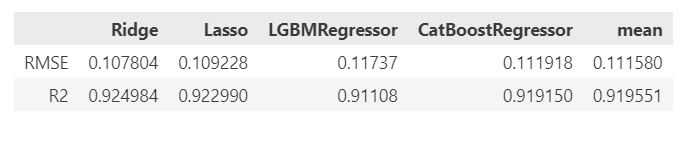

**1. the result improved** Remove line Bath\
 #df_upd['Bath'] = 0.225 * df['BsmtFullBath'] + (-0.0121) * df['BsmtHalfBath'] + 0.636 * df['FullBath'] + 0.343 * df['HalfBath']\
	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.107839	0.109357	0.118549	0.110127	**0.111468**\
R2	    0.924935	0.922807	0.909285	0.921716	0.919686\

2. Remove line
    #rem_id = [250, 314, 336, 496, 584, 935, 1299, 1329] **the result got worse**\
	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.121717	0.123135	0.145565	0.125641	0.129015\
R2		0.909447	0.907326	0.870488	0.903515	0.897694\


3.  Change filling GarageYrBlt with YearBuilt:**the result got worse**\
 df_upd['GarageYrBlt'] = df_upd['GarageYrBlt'].fillna(df_upd['YearBuilt']) #new_3 \
 	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.108765	0.109870	0.119354	0.112227	0.112554\
R2		0.923641	0.922081	0.908048	0.918702	0.918118\

4. Round prediction to nearest 500 **the result got worse**\
pred = np.log1p(np.round(np.exp(pred) / 500) * 500)\
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.107754	0.109337	0.117429	0.111843	0.111591\
R2		0.925054	0.922835	0.910991	0.919257	0.919534\

**5. the result improved** Round prediction to nearest 100 \
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.107798	0.109229	0.117388	0.111896	**0.111578**\
R2		0.924993	0.922988	0.911053	0.919181	0.919554\

**6. the result improved** Changed order in OrdinalEncoder: \
oec = OrdinalEncoder(categories = [['Po', 'Fa', 'NA', 'TA', 'Gd', 'Ex']]) \
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.108610	0.109345	0.117131	0.110971	**0.111514**\
R2		0.923858	0.922824	0.911442	0.920511	0.919659\

**7. the result improved** Added new feature Neighborhoodqual\
df_upd['Neighborhoodqual'] = df_upd.groupby('Neighborhood')['OverallQual'].transform('mean')\
	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.105718	0.106429	0.112291	0.106418	**0.107714**\
R2		0.927858	0.926885	0.918610	0.926900	0.925063\

**8. the result improved** Added new feature Totalarea\
df_upd['Totalarea'] = df_upd['GrLivArea'] + df_upd['LotArea']\
	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.107839	0.109302	0.115733	0.109190	**0.110516**\
R2		0.924935	0.922885	0.913544	0.923043	0.921102\

8.2 	With normalization Totalarea shows worse results:
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean
RMSE	0.107930	0.109299	0.116401	0.111180	0.111202
R2		0.924808	0.922889	0.912543	0.920212	0.920113

9. Added new 'HasGarage', 'HasBasement', 'HasFireplace'. **the result doesnt improve**\
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.107306	0.108882	0.11737	0.112784	0.111586\
R2		0.925675	0.923476	0.91108	0.917893	0.919531\

10. Top for now 1+6+7+8  **Kaggle 0.13095 score**\

Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.106576	0.106403	0.113151	0.106451	0.108145\
R2		0.926683	0.926921	0.917358	0.926855	0.924454\

In [12]:
# # Stack

# model = LinearRegression()
# model.fit(models_train_pred, y_test)
# fin_pred = model.predict(models_test_pred)

# # create submission file
# subm = pd.DataFrame()
# subm['Id'] = t_id.astype('int')
# subm['SalePrice'] = np.expm1(fin_pred)
# subm.set_index('Id').to_csv('submission_lm_stack.csv')


In [13]:
# # Stack

# model = LinearRegression()
# scaler = StandardScaler()
# models_train_pred_st = scaler.fit_transform(models_train_pred)
# models_test_pred_st = scaler.transform(models_test_pred)

# model.fit(models_train_pred_st, y_test)
# fin_pred = model.predict(models_test_pred_st)

# # create submission file
# subm = pd.DataFrame()
# subm['Id'] = t_id.astype('int')
# subm['SalePrice'] = np.expm1(fin_pred)
# subm.set_index('Id').to_csv('submission_upd_pp_stack.csv')


In [14]:
# # check feature importance
# imp = np.abs(gs_alg.best_estimator_.coef_)
# df_if = pd.DataFrame()
# df_if["feat"] = ifeatures
# df_if["lasso_imp"] = imp
# df_if.sort_values(by='lasso_imp',ascending=False)[:50]

# Non linear models

nothing there yet

In [15]:
# # prepare train / validation
# tdf = df.copy()
# tdf = fill_miss(tdf)

# #remove outliers
# tdf = tdf[~tdf['Id'].isin(rem_id)]

# # normalizing
# power = PowerTransformer(method='yeo-johnson', standardize=True)
# tdf[num_cols_norm] = power.fit_transform(tdf[num_cols_norm])

# # scaler = MinMaxScaler()
# # tdf[num_cols_norm] = scaler.fit_transform(tdf[num_cols_norm])

# tdf = feat_eng(tdf, num_cols_tdrop, num_cols_norm, num_cols_flag)
# tdf = transf_cat(tdf, cat_cols_oh, cat_cols_oe, cat_cols_tdrop)
# label = np.log1p(tdf['SalePrice'])
# tdf.drop(['Id', 'SalePrice'], axis=1, inplace=True)

# tdf = tdf[ifeatures]

In [16]:
# test_data = pd.read_csv('test.csv')

# test_data = fill_miss(test_data)
# # normalizing
# test_data[num_cols_norm] = power.transform(test_data[num_cols_norm])
# # test_data[num_cols_norm] = scaler.transform(test_data[num_cols_norm])
# test_data = feat_eng(test_data, num_cols_tdrop, num_cols_norm, num_cols_flag)
# test_data = transf_cat(test_data, cat_cols_oh, cat_cols_oe, cat_cols_tdrop)
# t_id = test_data['Id']
# test_data.drop('Id', axis=1, inplace=True)

# test_data = test_data[ifeatures]

## Models construction

In [17]:
# X_train, X_test, y_train, y_test = train_test_split(tdf, label, test_size=0.25, random_state=rst)
# # models_train_pred = pd.DataFrame()
# # models_test_pred = pd.DataFrame()

In [18]:
# model = SVR()

# # params_svr = {'C': [1, 5, 10, 24], 
# #             'degree': [1, 2, 3],
# #             'coef0': [0, 5, 10],
# #             'kernel': ["poly", "rbf", "sigmoid"]}

# params_svr = {'C': [10], 
#             'degree': [2],
#             'coef0': [10],
#             'kernel': ["poly"]}


# gs_alg = GridSearchCV(model, param_grid = params_svr, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

# gs_alg.fit(X_train, y_train)

# print(gs_alg.best_estimator_)

# pred = gs_alg.predict(X_test)
# pred_t = gs_alg.predict(test_data)
# models_train_pred[model.__class__.__name__] = pred
# models_test_pred[model.__class__.__name__] = pred_t

# rmse = (np.sqrt(mean_squared_error(y_test, pred)))
# r2 = r2_score(y_test, pred)
# print('Testing performance')
# print('RMSE: {:.3f}'.format(rmse))
# print('R2: {:.3f}'.format(r2), '\n')

In [19]:
# model = XGBRegressor()

# # params_xgb = {'n_estimators': [400, 700, 1000],
# #         'colsample_bytree': [0.7, 0.8],
# #         'max_depth': [15,20,25],
# #         'reg_alpha': [1.1, 1.2, 1.3],
# #         'reg_lambda': [1.1, 1.2, 1.3],
# #         'subsample': [0.7, 0.8, 0.9]
# #     }


# params_xgb = {'n_estimators': [1000],
#         'colsample_bytree': [1],
#         'max_depth': [4],
#         # 'reg_alpha': [1.1, 1.2, 1.3],
#         # 'reg_lambda': [1.1, 1.2, 1.3],
#         # 'subsample': [0.7, 0.8, 0.9]
#     }


# gs_alg = GridSearchCV(model, param_grid = params_xgb, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

# gs_alg.fit(X_train, y_train)

# print(gs_alg.best_estimator_)

# pred = gs_alg.predict(X_test)
# pred_t = gs_alg.predict(test_data)
# models_train_pred[model.__class__.__name__] = pred
# models_test_pred[model.__class__.__name__] = pred_t

# rmse = (np.sqrt(mean_squared_error(y_test, pred)))
# r2 = r2_score(y_test, pred)
# print('Testing performance')
# print('RMSE: {:.3f}'.format(rmse))
# print('R2: {:.3f}'.format(r2), '\n')

In [34]:
# model = RandomForestRegressor()

# # params_rfr = {'max_depth':[13, 20, 25, 30, 50],
# #         'n_estimators':[100, 400, 900],
# #         'max_features':[2, 6, 10, 15, 20]}

# # params_rfr = {'max_depth':[30],
# #         'n_estimators':[400],
# #         'max_features':[15]}

# params_rfr = {
#     'bootstrap': [True],
#     'max_depth': [30, 35, 40], #80, 90, 100, 110],
#     'max_features': [20, 25, 30], #10, 15, 
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [4, 6, 8], #10, 12],
#     'n_estimators': [400, 500, 600]
# }

# gs_alg = GridSearchCV(model, param_grid = params_rfr, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

# gs_alg.fit(X_train, y_train)

# print(gs_alg.best_estimator_)

# pred = gs_alg.predict(X_test)
# pred_t = gs_alg.predict(test_data)
# models_train_pred[model.__class__.__name__] = pred
# models_test_pred[model.__class__.__name__] = pred_t

# rmse = (np.sqrt(mean_squared_error(y_test, pred)))
# r2 = r2_score(y_test, pred)
# print('Testing performance')
# print('RMSE: {:.3f}'.format(rmse))
# print('R2: {:.3f}'.format(r2), '\n')

RandomForestRegressor(max_depth=35, max_features=25, min_samples_leaf=3,
                      min_samples_split=6, n_estimators=500)
Testing performance
RMSE: 0.126
R2: 0.898 



In [40]:
# models_train_pred

In [39]:
# sns.scatterplot(data=models_train_pred, x='Ridge', y='RandomForestRegressor')

In [24]:
# # Stack

# model = XGBRegressor()

# model.fit(models_train_pred, y_test)
# fin_pred = model.predict(models_test_pred)

# # create submission file
# subm = pd.DataFrame()
# subm['Id'] = t_id.astype('int')
# subm['SalePrice'] = np.expm1(fin_pred)
# subm.set_index('Id').to_csv('submission_all_stack_xgb.csv')

In [25]:
# # Stack
# model = LGBMRegressor(verbose=-1)

# # params_lgbm = {'n_estimators': [400, 1000],
# #         'learning_rate': [0.1],
# #         # 'colsample_bytree': [0.7, 0.8],
# #         'max_depth': [4, 8, 12],
# #         'num_leaves': [10, 50, 100, 150],
# #         'reg_alpha': [1.1, 1.2],
# #         'reg_lambda': [1.1, 1.2],
# #         'min_split_gain': [0.3, 0.4],
# #         'subsample': [0.8, 0.9],
# #         'subsample_freq': [10, 20]}

# # params_lgbm = {'learning_rate': [0.03, 0.05, 0.1],
# #                 "max_depth": [4, 8, 12],
# #                 "num_leaves": [100, 180], 
# #                 "max_bin": [200, 300],
# #                 'n_estimators': [250, 400]}

# params_lgbm = {'learning_rate': [0.03],
#                 "max_depth": [4],
#                 "num_leaves": [100], 
#                 "max_bin": [200],
#                 'n_estimators': [250]}


# gs_alg = GridSearchCV(model, param_grid = params_lgbm, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

# gs_alg.fit(models_train_pred, y_test)
# print(gs_alg.best_estimator_)

# fin_pred = gs_alg.predict(models_test_pred)

# # create submission file
# subm = pd.DataFrame()
# subm['Id'] = t_id.astype('int')
# subm['SalePrice'] = np.expm1(fin_pred)
# subm.set_index('Id').to_csv('submission_lm_cb_stack_lgb.csv')


LGBMRegressor(learning_rate=0.03, max_bin=200, max_depth=4, n_estimators=250,
              num_leaves=100, verbose=-1)


In [25]:
# # Stack

# # params_cb = {'iterations': [100, 400, 600],
# #              'learning_rate': [0.03, 0.1],
# #             'depth': [4, 6, 10],
# #             'l2_leaf_reg': [1, 3, 5, 7, 9]}

# # model = cb.CatBoostRegressor(verbose=False, loss_function='RMSE')
# # grid_search_result = model.grid_search(params_cb, X=models_train_pred, y=y_test, verbose=False)

# model = cb.CatBoostRegressor(verbose=False, loss_function='RMSE', depth=4, l2_leaf_reg=1, iterations=600, learning_rate=0.03)

# model.fit(models_train_pred, y_test)
# fin_pred = model.predict(models_test_pred)

# # create submission file
# subm = pd.DataFrame()
# subm['Id'] = t_id.astype('int')
# subm['SalePrice'] = np.expm1(fin_pred)
# subm.set_index('Id').to_csv('submission_all_stack_cb.csv')

In [20]:
# Stack

model = LinearRegression()
model.fit(models_train_pred, y_test)
fin_pred = model.predict(models_test_pred)

# create submission file
subm = pd.DataFrame()
subm['Id'] = t_id.astype('int')
subm['SalePrice'] = np.expm1(fin_pred)
subm.set_index('Id').to_csv('subm_lm_cb_lg_rf_stack.csv')


In [21]:
models_train_pred

,Ridge,Lasso,LGBMRegressor,CatBoostRegressor
0,11.936295,11.939024,11.946750,11.934333
1,12.459912,12.446771,12.404695,12.359902
2,11.889526,11.879763,11.839595,11.872755
3,12.464701,12.452977,12.533045,12.544822
4,11.778464,11.755455,11.795850,11.816291
...,...,...,...,...
358,11.724339,11.712784,11.754469,11.702133
359,12.281567,12.293820,12.229381,12.283939
360,12.672226,12.705130,12.830025,12.810333
361,12.989516,12.993816,12.919645,13.032724


In [22]:
subm

,Id,SalePrice
0,1461,123013.722585
1,1462,165561.905897
2,1463,194375.026717
3,1464,204824.852308
4,1465,206321.859603
...,...,...
1454,2915,81573.304306
1455,2916,82843.867536
1456,2917,164550.040865
1457,2918,119070.434452


# Lera's Version


In [41]:
# # Lera's addition to preprocessing

# cat_onehot = [
#     'MSZoning', 'LotConfig', 'Neighborhood', 'BldgType', 'Exterior1st', 'Exterior2nd', 'Foundation',
#     'BsmtExposure', 'GarageType', 'Fence', 'SaleType', 'SaleCondition', 'Heating'
# ]

# cols_to_drop = [
#     'Street', 'Alley', 'LotShape', 'LandContour', 'LandSlope', 'Condition2', 'HouseStyle', 'RoofStyle',
#     'RoofMatl', 'MasVnrType', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageQual',
#     'GarageCond', 'PoolQC', 'MiscFeature', 'LotFrontage', 'MasVnrArea', 'MiscVal',
#     'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'
# ]

In [42]:
# def updating_features(df):
#     """Creating ordinal & boolean features out of categorical/numerical"""
    
#     dfc = df.copy()
    
#     # fillna (w/respect to value distribution)
#     dfc['BsmtExposure'].fillna('No', inplace=True)
#     dfc['BsmtCond'] = dfc['BsmtCond'].fillna(df['BsmtCond'].mode()[0])  # before we convert to ordinal
#     dfc['BsmtQual'] = dfc['BsmtQual'].fillna(df['BsmtQual'].mode()[0])  # before we convert to ordinal
    
#     # ordinal
#     dfc['Utilities'] = dfc['Utilities'].replace({'AllPub': 100, 'NoSewr': 75,
#                                                  'NoSeWa': 50, 'ELO': 25})
    
#     dfc['Condition1'] = dfc['Condition1'].replace({'Feedr': -5, 'Artery': -5,
#                                                    'RRNn': -5, 'RRAn': -5,
#                                                    'RRNe': -5, 'RRAe': -5,
#                                                    'Norm': 0,
#                                                    'PosN': 5, 'PosA': 5})
    
#     # boolean
#     dfc['RegularLot'] = (dfc['LotShape'] == 'Reg').astype(int)
#     dfc['LevelLand'] = (dfc['LandContour'] == 'Lvl').astype(int)
#     dfc['GtlSlope'] = (dfc['LandSlope'] == 'Gtl').astype(int)
#     dfc['HipRoof'] = (dfc['RoofStyle'] == 'Hip').astype(int)
#     dfc['BrickOrStone'] = dfc['MasVnrType'].isin(['BrkFace', 'Stone']).astype(int)
#     dfc['GLQ'] = (dfc['BsmtFinType1'] == 'GLQ').astype(int)
#     dfc['CentralAir'] = (dfc['CentralAir'] == 'Y').astype(int)
#     dfc['SBrkr'] = (dfc['Electrical'] == 'SBrkr').astype(int)
#     dfc['Functional'] = (dfc['Functional'] == 'Typ').astype(int)
#     dfc['HasGoodFireplace'] = dfc['FireplaceQu'].isin(['Gd', 'TA', 'Fa', 'Ex']).astype(int)
#     dfc['GarageFinish'] = dfc['GarageFinish'].isin(['Fin', 'RFin']).astype(int)
#     dfc['PavedDrive'] = (dfc['PavedDrive'] == 'Y').astype(int)
    
#     top10neighborhoods = ['Blmngtn', 'SWISU', 'Edwards', 'Somerst', 'NoRidge', 'Timber', 'CollgCr']
#     dfc['NeighborhoodTop10'] = dfc['Neighborhood'].isin(top10neighborhoods).astype(int)
    
#     # uniting small categories
#     dfc['LotConfig'] = dfc['LotConfig'].replace({'FR2': 'Other', 'FR3': 'Other'})
#     dfc['HouseStyle'] = np.where(dfc['HouseStyle'].isin(['1.5Unf', '2.5Fin', '2.5Unf']),
#                                  'Other',
#                                  dfc['HouseStyle'])
    
#     ext_enough_observations = dfc['Exterior1st'].value_counts()[dfc['Exterior1st'].value_counts().ge(50)].keys()
#     dfc['Exterior1st'] = np.where(dfc['Exterior1st'].isin(ext_enough_observations), 
#                                   dfc['Exterior1st'],
#                                   'Other')
#     ext2_enough_observations = dfc['Exterior2nd'].value_counts()[dfc['Exterior2nd'].value_counts().ge(50)].keys()
#     dfc['Exterior2nd'] = np.where(dfc['Exterior2nd'].isin(ext2_enough_observations), 
#                                   dfc['Exterior2nd'],
#                                   'Other')
    
#     dfc['Heating'] = np.where(dfc['Heating'] == 'GasA', 'Gas', 'Other')
    
#     # quality dict
#     quality_dict = {'Ex': 10, 'Gd': 5, 'TA': 0, 'NA': 0, 'Fa': -5, 'Po': -10}
#     quality_cols = [
#         'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual'
#     ]
#     dfc[quality_cols] = dfc[quality_cols].replace(quality_dict)
    
#     # one feature instead of many
#     dfc['TotalBaths'] = dfc[['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']].fillna(0).sum(1)
    
#     return dfc
    

In [43]:
# from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PowerTransformer
# from sklearn.impute import SimpleImputer
# from sklearn.base import BaseEstimator, TransformerMixin


# def fill_miss(df):

#     df_upd = df.copy()

#     # fill columns wheare missing values have a meaning NA
#     feat_wn = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu',
#        'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtFinType2', 'BsmtExposure',
#        'BsmtFinType1', 'BsmtCond', 'BsmtQual']
    
#     for c in df_upd.columns:
#         if c in feat_wn:
#             df_upd[c].fillna('NA', inplace=True)

#     # fill with mean missing num features
#     num_si = SimpleImputer(strategy='mean')
#     num_col= df_upd.dtypes[df_upd.dtypes != 'object']
#     df_upd[num_col.index] = num_si.fit_transform(df_upd[num_col.index])

#     # fill with most frequent categorical features
#     cat_si = SimpleImputer(strategy='most_frequent')
#     cat_col= df_upd.dtypes[df_upd.dtypes == 'object']
#     df_upd[cat_col.index] = cat_si.fit_transform(df_upd[cat_col.index])


#     return df_upd

# def feat_eng(df, num_cols_tdrop, num_cols_norm, num_cols_flag):
#     df_upd = df.copy()


#     # create new feature for bathrooms
#     # corr coef
#     #     0.22512486719612368
#     # -0.012188876310787316
#     # 0.6359570562496957
#     # 0.34300754918568294

#     df_upd['Bath'] = 0.225 * df['BsmtFullBath'] + (-0.0121) * df['BsmtHalfBath'] + 0.636 * df['FullBath'] + 0.343 * df['HalfBath']

#     # drop columns
#     df_upd = df_upd.drop(num_cols_tdrop, axis=1)

#     # # normalizing
#     # power = PowerTransformer(method='yeo-johnson', standardize=True)
#     # df_upd[num_cols_norm] = power.fit_transform(df_upd[num_cols_norm])

#     for c in num_cols_flag:
#         if c in df_upd.columns:
#             df_upd[c] = df_upd[c].apply(lambda x: 1 if x>0 else 0)


#     return df_upd

# def transf_cat(df, cat_cols_oh, cat_cols_oe, cat_cols_tdrop):
#     df_upd = df.copy()

#     # merge values in LotConfig
#     if 'LotConfig' in  df_upd.columns:
#         df_upd.loc[df_upd['LotConfig']=='FR3', 'LotConfig'] = 'FR2'


#     #
#     if 'LandSlope' in  df_upd.columns:
#         df_upd.loc[df_upd['LandSlope']=='Sev', 'LandSlope'] = 'Mod'
#         df_upd['GtlSlope'] = df_upd['LandSlope'].apply(lambda x: 1 if x=='Gtl' else 0)
#         df_upd[['LandSlope', 'GtlSlope']][:5]

#     # merge values in Conditional1
#     for cc in [['RRNn', 'RRAn'], ['RRNe', 'RRAe'], ['PosN', 'PosA']]:
#         df_upd.loc[df_upd['Condition1']==cc[0], 'Condition1'] = cc[1]


#     # transform 
#     oec = OrdinalEncoder(categories = [['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']]) 
#     # for cc in ['FireplaceQu', 'KitchenQual', 'HeatingQC', 'PoolQC', 'BsmtQual', 'ExterQual', 'ExterCond']:
#     for cc in cat_cols_oe:
#         if cc in df_upd.columns:
#             df_upd[cc] = oec.fit_transform(df_upd[[cc]])

    
#     class GetDummiesTransformer(BaseEstimator, TransformerMixin):
#         def __init__(self, *args, pandas_params={}, **kwargs):
#             super().__init__(*args, **kwargs)
#             self._pandas_params = pandas_params
#         def fit(self, X, y=None):
#             return self
#         def transform(self, X, y=None):
#             return pd.get_dummies(X, dtype = 'int', **self._pandas_params)
    
#     df_upd = GetDummiesTransformer(pandas_params={'columns':cat_cols_oh}).transform(df_upd)

#     df_upd = df_upd.drop(cat_cols_tdrop, axis=1)

#     return df_upd

In [44]:
# # Lera's version

# tdf = df.copy()

# # updating cols
# tdf = updating_features(df)

# # dropping unnecessary
# tdf.drop(columns=cols_to_drop, inplace=True)

# # filling missing values
# tdf = fill_miss(tdf)

# # creating dummy variables
# assert tdf.select_dtypes(include='object').columns.tolist().sort() == cat_onehot.sort()
# onehot = pd.get_dummies(tdf[cat_onehot]).astype(int)
# tdf = tdf.select_dtypes(exclude='object').join(onehot)
# display(tdf.head())

# # all features are numeric
# assert tdf.select_dtypes(include='object').empty

# # no missing values
# assert tdf.isnull().sum().sum() == 0

# # split to test and label
# label = np.log1p(tdf['SalePrice'])
# tdf.drop(['Id', 'SalePrice'], axis=1, inplace=True)

# train_cols = tdf.columns.tolist()  # will use it later to reorder test columns

# # scaling
# power = PowerTransformer(method='yeo-johnson', standardize=True)
# tdf = power.fit_transform(tdf)

,Id,MSSubClass,LotArea,Utilities,Condition1,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,1.0,60.0,8450.0,100.0,0.0,7.0,5.0,2003.0,2003.0,5.0,...,0,0,0,0,0,0,0,0,0,1
1,2.0,20.0,9600.0,100.0,-5.0,6.0,8.0,1976.0,1976.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,3.0,60.0,11250.0,100.0,0.0,7.0,5.0,2001.0,2002.0,5.0,...,0,0,0,0,0,0,0,0,0,1
3,4.0,70.0,9550.0,100.0,0.0,7.0,5.0,1915.0,1970.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,5.0,60.0,14260.0,100.0,0.0,8.0,5.0,2000.0,2000.0,5.0,...,0,0,0,0,0,0,0,0,0,1


In [45]:
# test_data = pd.read_csv('test.csv')
# test = test_data.copy()
# t_id = test_data['Id']

# # updating cols
# test = updating_features(test)

# # dropping unnecessary
# test.drop(columns=cols_to_drop, inplace=True)

# # filling missing values
# test = fill_miss(test)

# # creating dummy variables
# assert test.select_dtypes(include='object').columns.tolist().sort() == cat_onehot.sort()
# onehot = pd.get_dummies(test[cat_onehot]).astype(int)
# test = test.select_dtypes(exclude='object').join(onehot)
# display(test.head())

# # all features are numeric
# assert test.select_dtypes(include='object').empty

# # no missing values
# assert test.isnull().sum().sum() == 0

# # removing ids
# test.drop(['Id'], axis=1, inplace=True)

# # adding cols missing in test (dummy cols) with 0s

# missing_cols_test = [c for c in train_cols if c not in test.columns]
# print(missing_cols_test)
# test[missing_cols_test] = 0

# # changing column order
# test = test.loc[:, train_cols]

# # scaling
# test_data = power.transform(test)

,Id,MSSubClass,LotArea,Utilities,Condition1,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,1461.0,20.0,11622.0,100.0,-5.0,5.0,6.0,1961.0,1961.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,1462.0,20.0,14267.0,100.0,0.0,6.0,6.0,1958.0,1958.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,1463.0,60.0,13830.0,100.0,0.0,5.0,5.0,1997.0,1998.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,1464.0,60.0,9978.0,100.0,0.0,6.0,6.0,1998.0,1998.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,1465.0,120.0,5005.0,100.0,0.0,8.0,5.0,1992.0,1992.0,5.0,...,0,0,0,0,0,0,0,0,0,1


['Exterior1st_BrkFace']


In [46]:
# X_train, X_test, y_train, y_test = train_test_split(tdf, label, test_size=0.25, random_state=rst)
# models_train_pred = pd.DataFrame()
# models_test_pred = pd.DataFrame()

In [47]:
# model = Ridge()

# params_ridge = {'alpha': np.arange(0.00, 3.0, 0.05), 'max_iter': [1000, None], 'random_state': [rst]}
# # params_ridge = {'alpha': [2.95], 'max_iter': [1000], 'random_state': [rst]}

# gs_alg = GridSearchCV(model, param_grid = params_ridge, cv = 10, scoring = 'neg_mean_squared_error', n_jobs=-1)

# gs_alg.fit(X_train, y_train)

# print(gs_alg.best_estimator_)

# pred = gs_alg.predict(X_test)
# pred_t = gs_alg.predict(test_data)
# models_train_pred[model.__class__.__name__] = pred
# models_test_pred[model.__class__.__name__] = pred_t

# rmse = (np.sqrt(mean_squared_error(y_test, pred)))
# r2 = r2_score(y_test, pred)
# print('Testing performance')
# print('RMSE: {:.3f}'.format(rmse))
# print('R2: {:.3f}'.format(r2), '\n')

Ridge(alpha=2.95, max_iter=1000, random_state=44)
Testing performance
RMSE: 0.128
R2: 0.900 



In [48]:
# model = Lasso()

# params_lasso = {'alpha': np.arange(0.001, 1.0, 0.002), 'max_iter': [100, 300, 1000], 'random_state': [rst]}
# # params_lasso = {'alpha': [0.001], 'max_iter': [300], 'random_state': [rst]}

# gs_alg = GridSearchCV(model, param_grid = params_lasso, cv = 10, scoring = 'neg_mean_squared_error', n_jobs=-1)

# gs_alg.fit(X_train, y_train)

# print(gs_alg.best_estimator_)

# pred = gs_alg.predict(X_test)
# pred_t = gs_alg.predict(test_data)
# models_train_pred[model.__class__.__name__] = pred
# models_test_pred[model.__class__.__name__] = pred_t

# rmse = (np.sqrt(mean_squared_error(y_test, pred)))
# r2 = r2_score(y_test, pred)
# print('Testing performance')
# print('RMSE: {:.3f}'.format(rmse))
# print('R2: {:.3f}'.format(r2), '\n')

/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.769e-02, tolerance: 1.510e-02
  model = cd_fast.enet_coordinate_descent(
/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.240e-02, tolerance: 1.576e-02
  model = cd_fast.enet_coordinate_descent(
/Users/evgenia_k/miniconda3/envs/py4dp/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

Lasso(alpha=0.005, max_iter=100, random_state=44)
Testing performance
RMSE: 0.123
R2: 0.908 



In [ ]:
# # Stack

# model = LinearRegression()
# model.fit(models_train_pred, y_test)
# fin_pred = model.predict(models_test_pred)

# # create submission file
# subm = pd.DataFrame()
# subm['Id'] = t_id.astype('int')
# subm['SalePrice'] = np.expm1(fin_pred)
# subm.set_index('Id').to_csv('submission_lm_lera_stack.csv')

# Linear models

Since linear models sensitive to correlation, we will remove features which have high correlation with each other. They are fixed in <b>col_tdrop_linm</b> 

What was tested:
<h5>1. - wo #1stFlrSF', '2ndFlrSF', <br>
- with MinMaxScaler()</h5><br>

1.1. <b>Lasso</b>(alpha=0.0, random_state=44) | grid search was {'alpha': np.arange(0.00, 1.0, 0.005), 'max_iter': [1000, 1200], 'random_state': [rst]}<br>
Testing performance<br>
RMSE: 0.124<br>
R2: 0.900 <br>
it doesn't converege<br>
kaggle: 0.15107<br>

1.2. <b>LassoCV</b><br>
return parametrs
{'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': False}<br>
RMSE: 0.134<br>
R2: 0.884 <br>
kaggle - 

1.3. <b>Lasso</b>(alpha=0.001, max_iter=100, random_state=44) | grid search was {'alpha': np.arange(0.001, 1.0, 0.002), 'max_iter': [100, 300, 1000, None], 'random_state': [rst]}<br>
Testing performance<br>
RMSE: 0.112<br>
R2: 0.918 <br>
kaggle: <b>0.14718</b>

1.4. <b>RidgeCV</b><br>
Testing performance
{'alpha_per_target': False, 'alphas': (0.1, 1.0, 10.0), 'cv': None, 'fit_intercept': True, 'gcv_mode': None, 'scoring': None, 'store_cv_values': False}<br>
RMSE: 0.109<br>
R2: 0.923 <br>
kaggle: 0.14996<br>

<h5>2. - with Power Transformer ()</h5><br>
2.1. <b>Lasso</b> (alpha=0.001, max_iter=100, random_state=44) | GS was {'alpha': np.arange(0.001, 1.0, 0.002), 'max_iter': [100, 300, 1000, None], 'random_state': [rst]}<br>
Testing performance<br>
RMSE: 0.109<br>
R2: 0.923 <br>
kaggle: 0.14174

2.2. <b>Ridge</b>(alpha=2.95, max_iter=1000, random_state=44) | GS was {'alpha': np.arange(0.00, 3.0, 0.05), 'max_iter': [1000, None], 'random_state': [rst]}<br>
Testing performance<br>
RMSE: 0.109<br>
R2: 0.923 <br>
kaggle: 0.14072



<h5>3. <b>all features with Power Transformer ()</b></h5><br>
3.1. <b>Ridge</b>(alpha=2.95, max_iter=1000, random_state=44) | gs was {'alpha': np.arange(0.00, 3.0, 0.05), 'max_iter': [1000, None], 'random_state': [rst]}<br>
Testing performance<br>
RMSE: 0.110<br>
R2: 0.921 <br>
kaggle: <b>0.13981</b>

3.2. <b>Lasso</b>(alpha=0.001, max_iter=100, random_state=44) | gs was {'alpha': np.arange(0.001, 1.0, 0.002), 'max_iter': [100, 300, 1000, None], 'random_state': [rst]}<br>
Testing performance<br>
RMSE: 0.110<br>
R2: 0.921 <br>
kaggle: <b>0.14141 </b>

3.3. <b>Stack model</b> of 3.1 and 3.2<br>
LinearRegression<br>
kaggle: <b>0.13672</b><br>

3.4. <b>SVR</b>(C=10, coef0=10, degree=2, kernel='poly') | gs was {'C': [1, 5, 10, 24], 'degree': [1, 2, 3], 'coef0': [0, 5, 10], 'kernel': ["poly", "rbf", "sigmoid"]}<br>
Testing performance<br>
RMSE: 0.108<br>
R2: 0.924 <br>
kaggle 0.14329

3.5. <b>Stack model</b> of 3.1, 3.2 and 3.3 <br>
LinearRegression<br>
kaggle: <b>0.14156</b><br>

3.6. <b>Stack model</b> of 3.1, 3.2 with StandartScaler <br>
LinearRegression<br>
kaggle: <b>0.14045</b><br>